In [9]:
#allows to connect to a database
%pip install ipython-sql
#load the ipython extension for use
%load_ext sql
#add database path to it (convention)
%sql sqlite://

Note: you may need to restart the kernel to use updated packages.
The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [10]:
import sqlite3
from sqlite3 import Error as Err
from enum import unique
from pathlib import Path, PurePath
import pandas as pd
import sys 
import re #for replacing non alphanumeric characters in string

In [11]:
# explicit function to connect  database
# that resides in the memory
def SQLite_connection_and_db_update(dbname_path, file_name):
 
    try:
        # connect to the database
        Path(dbname_path).touch()
        conn = sqlite3.connect(dbname_path)
        print("Database connection is established successfully!")
        c = conn.cursor()
 
    # if any interruption or error occurs
    except Err: print(Err)
 
    # terminate the connection   
    finally: 
        path = PurePath(file_name)
        table_name = pd.read_csv(file_name) #spark.read.csv(file_name, header=True,inferSchema=True) 
        path_name = path.name
        print(path_name)
        table_name.to_sql(path_name, conn, if_exists='append', index = False)
        conn.commit()
        print(c.execute("SELECT name FROM sqlite_master WHERE type = 'table'").fetchall())
        return c, path_name, table_name

In [12]:
#Note: Use delete_all_tables to get rid of all tables in existing database

TABLE_PARAMETER = "{TABLE_PARAMETER}"
DROP_TABLE_SQL = f"DROP TABLE {TABLE_PARAMETER};"
GET_TABLES_SQL = "SELECT name FROM sqlite_schema WHERE type='table';"


def delete_all_tables(con):
    '''
    Delete all tables present in a given database
    '''
    
    tables = get_tables(con)
    delete_tables(con, tables)


def get_tables(con):
    cur = con.cursor()
    cur.execute(GET_TABLES_SQL)
    tables = cur.fetchall()
    cur.close()
    return tables


def delete_tables(con, tables):
    cur = con.cursor()
    for table, in tables:
        sql = DROP_TABLE_SQL.replace(TABLE_PARAMETER, table)
        cur.execute(sql)
    cur.close()

In [13]:
#One of the issues is to implicitly retrieve columns instead of manually naming  them in your_table_name
#FIXES: NO column names nor key values are added to new database table. Only table creation was successful so far


def extract_nth_element_from_list_of_tuples(tuple_list, n):
    '''
    Convert list of tuples to list of strings via list comprehension
    '''
    result = list(map (lambda x:(x[n]), tuple_list))
    return result



def join_database(database1Name, database3Name): 

    ''' 
    Join database 'database1Name' into database 'database3Name' 
    ''' 
    # Connect to Database1  
    con1 = sqlite3.connect(database1Name)      
    
    # Connect to Database3 
    con3_initial = sqlite3.connect(database3Name)  

    #Include here because of liimited sqlite 3 capabilities. Further down it locks database     
    delete_all_tables(con3_initial) 
    con3 = sqlite3.connect(database3Name)

    tuples_of_tables = con1.cursor().execute('SELECT name from sqlite_master where type="table"').fetchall()
    list_of_tables = extract_nth_element_from_list_of_tuples(tuples_of_tables, 0)
    table = list_of_tables[0]
    new_table = table + '_new'
    
    #For reading column names from Database1. Note: This changes what's displayed when using .fetchall but to read as sqlite3 table it's required
    con1.row_factory = sqlite3.Row         
    con3.row_factory = sqlite3.Row

    # Create new connection with Database1 for reading data  
    con1_new = sqlite3.connect(database1Name)   
 
    with con1, con3, con1_new: 
        cur1 = con1.cursor()            
        cur1_new = con1_new.cursor()      
        cur3 = con3.cursor()
        cur1.execute('SELECT name from sqlite_master where type="table"')
        cur1.execute(f"SELECT * FROM {table}") 
        row_1 = cur1.fetchone()     
        columnNames = row_1.keys()  
        cur3.execute(f"CREATE TABLE IF NOT EXISTS {new_table} (Id INTEGER PRIMARY KEY)")
        #Note: No need to commit transaction/changes, auto-commit mode is enabled by  default
        
        new_column_names = []
        for col in columnNames[1:]:
            new_col = re.sub('[^0-9a-zA-Z]','_', col)
            new_column_names.append(new_col)
            cur3.execute(f"ALTER TABLE {new_table} ADD {new_col} TEXT")

        cur1_new.execute(f'SELECT * FROM {table}')
        rows1 = cur1_new.fetchall() 
        rows1 = [r[1:] for r in rows1] 
        ques = []   
        # Generate list [?, ?, ?, ?,........till length equals length of columnNames[1:]          
        ques = ["?"]*len(new_column_names[0:]) 
        # Generate string "?,?,?,?,?........"    
        ques = ",".join(ques) 
        # Generate string "col1, col2, col3............"         
        columnNames = ",".join(new_column_names[0:]) 
        # Insert combined data into new Database3     
        for item in rows1:  
            cur3.execute("INSERT INTO {0}({1}) VALUES ({2})".format(new_table, columnNames, ques), item)
            
    return con3, new_column_names
      

In [14]:
#Add file to database with given table name and operate on it in cmds below
dbname_path = r'C:\Users\spyro\sql.practice.local.pc\sales_data.db'
file_name = r'C:\Users\spyro\python.replace.excel.functionality\demo_files\sales-data-1M.csv'
returned_c_path_name = SQLite_connection_and_db_update(dbname_path, file_name)
print(returned_c_path_name[1])

Database connection is established successfully!
sales-data-1M.csv
[('sales-data-1M.csv',)]
sales-data-1M.csv


In [15]:
#analyse total revenue by product category
product_revenue = returned_c_path_name[0].execute('''SELECT SUM(revenue), product FROM `sales-data-1M.csv` GROUP BY product''').fetchall() 

#Convert into dictionary (it's in the form of tuples) for visualisation purposes
prod_rev_dic = {}
for (value, key) in product_revenue:
   prod_rev_dic.setdefault(key, []).append(value)
prod_rev_dic

{1: [181736], 2: [181028], 3: [178944], 4: [78528733], 5: [164800]}


New DataFrame:
         product      date  quantity  revenue day month year
0              2    4/1/20         8      298   4     1   20
1              1  10/13/20         1      344  10    13   20
2              1   7/17/20         6      298   7    17   20
3              2  10/18/20         1      377  10    18   20
4              4   3/26/20         1      163   3    26   20
...          ...       ...       ...      ...  ..   ...  ...
1048570        4   7/13/20         6       75   7    13   20
1048571        4   7/13/20         6       75   7    13   20
1048572        4   7/13/20         6       75   7    13   20
1048573        4   7/13/20         6       75   7    13   20
1048574        4   7/13/20         6       75   7    13   20

[1048575 rows x 7 columns]


array([<AxesSubplot:title={'center':'revenue'}, xlabel='product,year'>],
      dtype=object)

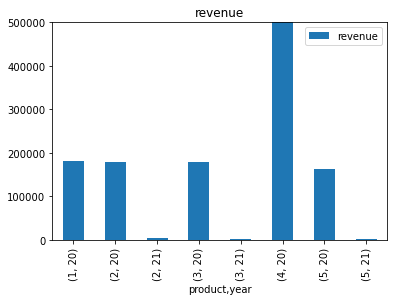

In [130]:
#Further manipulation to separate date into month, day and year
returned_c_path_name[2][["day", "month", "year"]] = returned_c_path_name[2]["date"].str.split("/", expand = True)
print("\nNew DataFrame:")
print(returned_c_path_name[2])

#just use python dataframes
yearly_revenue_by_product = (returned_c_path_name[2].groupby(['product', 'year'], axis = 0)['revenue'].sum()).to_frame()
#print(yearly_revenue_by_product.unstack(level = 1))

#plot results into scatter diagram
yearly_revenue_by_product.plot(kind='bar', subplots=True, ylim = (0,500000))


In [16]:
#Tranfer tables from 1 database to another one that was created in the path specified below
Path(r'C:\Users\spyro\sql.practice.local.pc\local_databases\SQL_SAFI.new_db.db').touch()
db_new = r'C:\Users\spyro\sql.practice.local.pc\local_databases\SQL_SAFI.new_db.db'
db_original = r'C:\Users\spyro\sql.practice.local.pc\local_databases\SQL_SAFI.sqlite'
connect, columns = join_database(db_original, db_new)
#Note: use.row_factory to execute .keys method in join_database function (for con3)
print(connect.cursor().execute("SELECT * FROM Farms_new").fetchone().keys())

['Id', 'Country', 'A01_interview_date', 'A03_quest_no', 'A04_start', 'A05_end', 'A06_province', 'A07_district', 'A08_ward', 'A09_village', 'A11_years_farm', 'A12_agr_assoc', 'B_no_membrs', '_members_count', 'B11_remittance_money', 'B16_years_liv', 'B17_parents_liv', 'B18_sp_parents_liv', 'B19_grand_liv', 'B20_sp_grand_liv', 'C01_respondent_roof_type', 'C02_respondent_wall_type', 'C03_respondent_floor_type', 'C04_window_type', 'C05_buildings_in_compound', 'C06_rooms', 'C07_other_buildings', 'D_no_plots', 'D_plots_count', 'E01_water_use', 'E_no_group_count', 'E_yes_group_count', 'E17_no_enough_water', 'E18_months_no_water', 'E19_period_use', 'E20_exper_other', 'E21_other_meth', 'E22_res_change', 'E23_memb_assoc', 'E24_resp_assoc', 'E25_fees_water', 'E26_affect_conflicts', 'F04_need_money', 'F05_money_source', 'F05_money_source_other', 'F08_emply_lab', 'F09_du_labour', 'F10_liv_owned', 'F10_liv_owned_other', 'F_liv_count', 'F12_poultry', 'F13_du_look_aftr_cows', 'F14_items_owned', 'G01_no

In [17]:
#Check delete function okay
print(connect.cursor().execute('SELECT name from sqlite_master where type="table"').fetchall()) # created table but no keys
row = connect.cursor().fetchone()
delete_all_tables(connect)
print(connect.cursor().fetchone())

None


In [1]:
#Practice run with pyspark

import os
from os.path import expanduser, join, abspath
import pyspark
from pyspark.sql import functions, SparkSession, Row, HiveContext
from pyspark.sql import Row

In [2]:
#Launch sparksession, create database and use spark dataframes

#Note: Can also set the spark context and then create and run the sparksession
#spark = SparkSession.builder.appName("students").getOrCreate()
#spark = SparkSession.builder.config('spark.port.maxRetries', 16).getOrCreate() 

sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

db_name = "student_data"
spark.sql(f"CREATE DATABASE IF NOT EXISTS {db_name}")


#read csv data into dataframe
StudentsPerformance_csv = spark.read.csv(r'C:\Users\spyro\python.replace.excel.functionality\demo_files\StudentsPerformance.csv',header=True,inferSchema=True)
StudentsPerformance_csv.printSchema()
StudentsPerformance_csv.show()


#Note: createGlobalTempView shared across all sessions even though on emay be terminated
StudentsPerformance_csv.createOrReplaceTempView("StudentsPerformance_csv")


students_performance_stats = StudentsPerformance_csv.describe()
students_performance_stats.show()
#Note stats are stringified by default and null values still allowed
students_performance_stats.printSchema()
spark.sql("SHOW TABLES").show(truncate=False)

root
 |-- gender: string (nullable = true)
 |-- group: string (nullable = true)
 |-- math score: integer (nullable = true)
 |-- reading score: integer (nullable = true)
 |-- writing score: integer (nullable = true)

+------+-------+----------+-------------+-------------+
|gender|  group|math score|reading score|writing score|
+------+-------+----------+-------------+-------------+
|  male|group B|        38|           93|           28|
|female|group D|        96|           30|            7|
|  male|group E|        42|           22|            4|
|  male|group C|        14|           83|           23|
|  male|group B|        55|           28|           20|
|  male|group D|        40|           23|           95|
|  male|group D|        23|           58|           28|
|female|group B|        26|           35|           97|
|  male|group A|        89|           39|           45|
|female|group C|        18|           31|           58|
|female|group B|        26|           77|           95|


In [3]:

#spark.sql(f"CREATE TABLE student_data.studentsperformance_csv")
spark.sql(f"ALTER DATABASE {db_name} SET DBPROPERTIES ('Edited-by' = 'spyros', 'Edit-date' = '28/08/2022')")
spark.sql(f"DESCRIBE DATABASE EXTENDED {db_name}").show(truncate=False)
#nothing yet committed before closing spark session
spark.sql("show databases").show(truncate=False)

+-------------------------+--------------------------------------------------------------------------+
|database_description_item|database_description_value                                                |
+-------------------------+--------------------------------------------------------------------------+
|Database Name            |student_data                                                              |
|Comment                  |                                                                          |
|Location                 |file:/c:/Users/spyro/sql.practice.local.pc/spark-warehouse/student_data.db|
|Owner                    |                                                                          |
|Properties               |((Edited-by,spyros), (Edit-date,28/08/2022))                              |
+-------------------------+--------------------------------------------------------------------------+

+------------+
|namespace   |
+------------+
|default     |
|student_dat